(smoothing_tax)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Tax Smoothing with Complete and Incomplete Markets

```{index} single: Smoothing; Tax
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture uses the  library:

In [1]:
!pip install --upgrade quantecon

## Overview

This lecture describes tax-smoothing models that are counterparts to consumption-smoothing models in {doc}`Consumption Smoothing with Complete and Incomplete Markets <smoothing>`.

* one is in the **complete markets** tradition of Lucas and Stokey {cite}`LucasStokey1983`.
* the other is in the **incomplete markets** tradition  of  Barro {cite}`Barro1979`.

*Complete markets* allow a  government to buy or sell claims contingent on all possible Markov states.

*Incomplete markets* allow a  government to buy or sell only a limited set of securities, often only a single risk-free security.

Barro {cite}`Barro1979`  worked in an incomplete markets tradition by assuming
that the only asset that can be traded is a risk-free one period bond.

In his consumption-smoothing model, Hall {cite}`Hall1978` had  assumed an exogenous stochastic process of nonfinancial income and
an exogenous gross interest rate on one period risk-free debt that equals
$\beta^{-1}$, where $\beta \in (0,1)$ is also a consumer's
intertemporal discount factor.

Barro {cite}`Barro1979` made an analogous assumption about the risk-free interest
rate in a tax-smoothing model that turns out to have the same mathematical structure as Hall's
consumption-smoothing model.

To get Barro's model from Hall's, all we have to do is to rename variables.

We maintain Hall's and Barro's assumption about the interest rate when we describe an
incomplete markets version of our model.

In addition, we extend their assumption about the interest rate to an appropriate counterpart to create a "complete markets" model in the style of
Lucas and Stokey {cite}`LucasStokey1983`.

### Isomorphism between Consumption and Tax Smoothing

For each version of a consumption-smoothing model,  a tax-smoothing counterpart can be obtained simply by relabeling

* consumption as tax collections
* a consumer's one-period utility function as a government's one-period loss function from collecting taxes that impose deadweight welfare losses
* a consumer's  nonfinancial income as a government's purchases
* a consumer's *debt* as a government's *assets*

Thus, we can convert  the consumption-smoothing models in lecture {doc}`Consumption Smoothing with Complete and Incomplete Markets <smoothing>` into  tax-smoothing models by setting
$c_t = T_t$, $y_t = G_t$, and $- b_t = a_t$,  where $T_t$ is total tax
collections, $\{G_t\}$ is an exogenous government expenditures
process, and $a_t$ is the government's holdings of one-period risk-free bonds coming maturing at the due at the beginning of time $t$.

For elaborations on this theme, please see [Optimal Savings II: LQ Techniques](https://python-intro.quantecon.org/perm_income_cons.html) and later parts of this lecture.

We'll spend most of this lecture studying acquire finite-state Markov specification,
but will also  treat the linear state space specification.

#### Link to History

For those who love history, President Thomas Jefferson's Secretary of Treasury Albert Gallatin (1807) {cite}`Gallatin` seems to have prescribed policies that
come from Barro's model {cite}`Barro1979`

Let's start with some standard imports:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la

To exploit the isomorphism between consumption-smoothing and tax-smoothing models, we  simply use code from {doc}`Consumption Smoothing with Complete and Incomplete Markets <smoothing>`

### Code

Among other things, this code contains a function called `consumption_complete()`.

This function computes $\{ b(i) \}_{i=1}^{N}, \bar c$ as outcomes given a set of parameters for the general case with $N$ Markov states
under the assumption of complete markets

In [3]:
class ConsumptionProblem:
    """
    The data for a consumption problem, including some default values.
    """

    def __init__(self,
                 β=.96,
                 y=[2, 1.5],
                 b0=3,
                 P=[[.8, .2],
                    [.4, .6]],
                 init=0):
        """
        Parameters
        ----------

        β : discount factor
        y : list containing the two income levels
        b0 : debt in period 0 (= initial state debt level)
        P : 2x2 transition matrix
        init : index of initial state s0
        """
        self.β = β
        self.y = np.asarray(y)
        self.b0 = b0
        self.P = np.asarray(P)
        self.init = init

    def simulate(self, N_simul=80, random_state=1):
        """
        Parameters
        ----------

        N_simul : number of periods for simulation
        random_state : random state for simulating Markov chain
        """
        # For the simulation define a quantecon MC class
        mc = qe.MarkovChain(self.P)
        s_path = mc.simulate(N_simul, init=self.init, random_state=random_state)

        return s_path


def consumption_complete(cp):
    """
    Computes endogenous values for the complete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem

    Returns
    -------

        c_bar : constant consumption
        b : optimal debt in each state

    associated with the price system

        Q = β * P
    """
    β, P, y, b0, init = cp.β, cp.P, cp.y, cp.b0, cp.init   # Unpack

    Q = β * P                               # assumed price system

    # construct matrices of augmented equation system
    n = P.shape[0] + 1

    y_aug = np.empty((n, 1))
    y_aug[0, 0] = y[init] - b0
    y_aug[1:, 0] = y

    Q_aug = np.zeros((n, n))
    Q_aug[0, 1:] = Q[init, :]
    Q_aug[1:, 1:] = Q

    A = np.zeros((n, n))
    A[:, 0] = 1
    A[1:, 1:] = np.eye(n-1)

    x = np.linalg.inv(A - Q_aug) @ y_aug

    c_bar = x[0, 0]
    b = x[1:, 0]

    return c_bar, b


def consumption_incomplete(cp, s_path):
    """
    Computes endogenous values for the incomplete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem
    s_path : the path of states
    """
    β, P, y, b0 = cp.β, cp.P, cp.y, cp.b0  # Unpack

    N_simul = len(s_path)

    # Useful variables
    n = len(y)
    y.shape = (n, 1)
    v = np.linalg.inv(np.eye(n) - β * P) @ y

    # Store consumption and debt path
    b_path, c_path = np.ones(N_simul+1), np.ones(N_simul)
    b_path[0] = b0

    # Optimal decisions from (12) and (13)
    db = ((1 - β) * v - y) / β

    for i, s in enumerate(s_path):
        c_path[i] = (1 - β) * (v - np.full((n, 1), b_path[i]))[s, 0]
        b_path[i + 1] = b_path[i] + db[s, 0]

    return c_path, b_path[:-1], y[s_path]

### Revisiting the consumption-smoothing model

The code above also contains a function called `consumption_incomplete()` that uses {eq}`cs_12` and {eq}`cs_13` to

* simulate paths of $y_t, c_t, b_{t+1}$
* plot these against values of $\bar c, b(s_1), b(s_2)$ found in a corresponding  complete markets economy

Let's try this, using the same parameters in both complete and incomplete markets economies

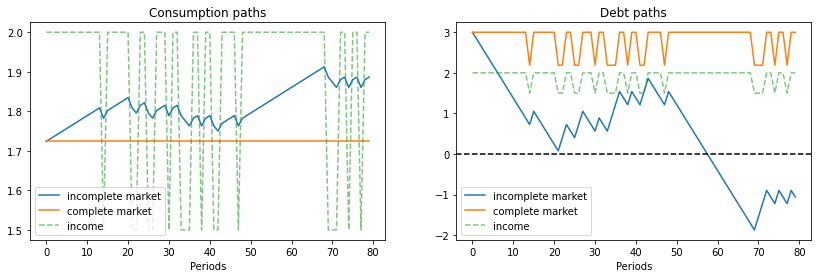

In [4]:
cp = ConsumptionProblem()
s_path = cp.simulate()
N_simul = len(s_path)

c_bar, debt_complete = consumption_complete(cp)

c_path, debt_path, y_path = consumption_incomplete(cp, s_path)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].set_title('Consumption paths')
ax[0].plot(np.arange(N_simul), c_path, label='incomplete market')
ax[0].plot(np.arange(N_simul), np.full(N_simul, c_bar), label='complete market')
ax[0].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')

ax[1].set_title('Debt paths')
ax[1].plot(np.arange(N_simul), debt_path, label='incomplete market')
ax[1].plot(np.arange(N_simul), debt_complete[s_path], label='complete market')
ax[1].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()

In the graph on the left, for the same sample path of nonfinancial
income $y_t$, notice that

* consumption is constant when there are complete markets.
* consumption takes a random walk in the incomplete markets version of the model.
* the consumer's debt oscillates between two values that are functions
  of the Markov state in the complete markets model.
* the consumer's debt  drifts because it contains a unit root in the incomplete markets economy.

#### Relabeling variables to create tax-smoothing models

As indicated above, we relabel variables to acquire tax-smoothing interpretations of the complete markets and incomplete markets consumption-smoothing models.

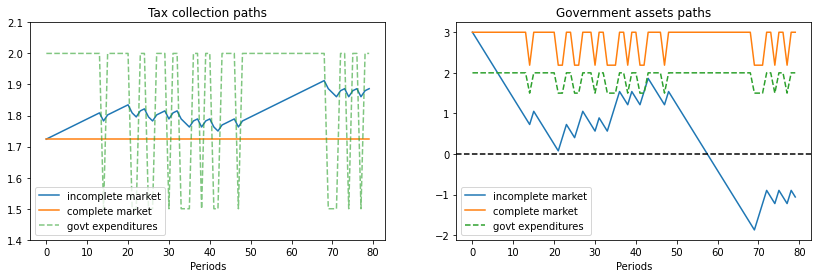

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].set_title('Tax collection paths')
ax[0].plot(np.arange(N_simul), c_path, label='incomplete market')
ax[0].plot(np.arange(N_simul), np.full(N_simul, c_bar), label='complete market')
ax[0].plot(np.arange(N_simul), y_path, label='govt expenditures', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')
ax[0].set_ylim([1.4, 2.1])

ax[1].set_title('Government assets paths')
ax[1].plot(np.arange(N_simul), debt_path, label='incomplete market')
ax[1].plot(np.arange(N_simul), debt_complete[s_path], label='complete market')
ax[1].plot(np.arange(N_simul), y_path, label='govt expenditures', ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()

## Tax Smoothing with Complete Markets

It is instructive  to focus on a simple tax-smoothing example with complete markets.

This example illustrates how, in a complete markets model like that of Lucas and Stokey {cite}`LucasStokey1983`, the government purchases
insurance from the private sector.

Payouts from the insurance it had purchased  allows the government to avoid raising taxes when  emergencies make government expenditures surge.

We assume that government expenditures take one of two values $G_1 < G_2$, where Markov state $1$ means "peace" and Markov state $2$ means "war".

The government budget constraint in Markov state $i$ is

$$
T_i + b_i = G_i + \sum_j Q_{ij} b_j
$$

where

$$
Q_{ij} = \beta P_{ij}
$$

is the price today of one unit of goods in Markov  state   $j$ tomorrow when
the Markov state is $i$ today.

$b_i$ is the government's level of *assets* when it arrives in Markov state $i$.

That is, $b_i$ equals  one-period state-contingent claims *owed to the government* that fall due at time $t$ when the Markov state is $i$.

Thus, if $b_i < 0$, it means the government **is owed** $b_i$ or **owes** $-b_i$ when the economy arrives in Markov state $i$ at time
$t$.

In our examples below, this  happens when in a previous war-time  period the government has sold an Arrow securities paying off $- b_i$
in peacetime Markov state $i$

It can be enlightening to express the government's budget constraint in Markov state $i$ as

$$
T_i = G_i +  \left(\sum_j Q_{ij} b_j -   b_i\right)
$$

in which the term $(\sum_j Q_{ij} b_j -   b_i)$   equals the net amount that the government spends to purchase one-period Arrow securities
that will pay off next period in Markov states $j = 1, \ldots, N$ after it has received payments $b_i$ this period.

## Returns on State-Contingent Debt

Notice that $\sum_{j'=1}^N Q_{ij'} b(j')$ is the amount that the government spends  in Markov state $i$ at time $t$ to purchase
one-period state-contingent claims that will pay off in Markov state $j'$ at time $t+1$.

Then the *ex post* one-period gross return on the portfolio of government assets  held from state $i$ at time $t$
to state $j$ at time $t+1$  is

$$
R(j | i) = \frac{b(j) }{ \sum_{j'=1}^N Q_{ij'} b(j') }
$$

The cumulative return earned from putting $1$ unit of time $t$ goods into the government portfolio of state-contingent securities at
time $t$ and then rolling over the proceeds into the government portfolio each period thereafter is

$$
R^T(s_{t+T}, s_{t+T-1}, \ldots, s_t) \equiv R(s_{t+1} | s_t) R (s_{t+2} | s_{t+1} )
\cdots R(s_{t+T} | s_{t+T-1} )
$$

Here is some code that computes one-period and cumulative returns on the government portfolio in the finite-state Markov version of our complete
markets model.

**Convention:**  In this code, when $P_{ij}=0$,  we arbitrarily set $R(j | i)$ to be $0$.

In [6]:
def ex_post_gross_return(b, cp):
    """
    calculate the ex post one-period gross return on the portfolio
    of government assets, given b and Q.
    """
    Q = cp.β * cp.P

    values = Q @ b

    n = len(b)
    R = np.zeros((n, n))

    for i in range(n):
        ind = cp.P[i, :] != 0
        R[i, ind] = b[ind] / values[i]

    return R

def cumulative_return(s_path, R):
    """
    compute cumulative return from holding 1 unit market portfolio
    of government bonds, given some simulated state path.
    """
    T = len(s_path)

    RT_path = np.empty(T)
    RT_path[0] = 1
    RT_path[1:] = np.cumprod([R[s_path[t], s_path[t+1]] for t in range(T-1)])

    return RT_path

### An Example of Tax Smoothing

We'll study a tax-smoothing model with two Markov states.

In Markov state $1$, there is peace and government expenditures are low.

In Markov state $2$, there is war and government expenditures are high.

We'll compute optimal policies in both complete and incomplete markets settings.

Then we'll feed in a **particular** assumed path of Markov states and study outcomes.

* We'll assume that the initial Markov state is state $1$, which means we start from a state of peace.
* The government  then experiences 3 time periods of war and come back to peace again.
* The history of Markov states is therefore $\{ peace, war, war, war, peace \}$.

In addition, as indicated above, to simplify our example, we'll set the government's initial
asset level to $1$, so that $b_1 = 1$.

Here's code that itinitializes government assets to be unity in an initial peace time  Markov state.

In [7]:
# Parameters
β = .96

# change notation y to g in the tax-smoothing example
g = [1, 2]
b0 = 1
P = np.array([[.8, .2],
              [.4, .6]])

cp = ConsumptionProblem(β, g, b0, P)
Q = β * P

# change notation c_bar to T_bar in the tax-smoothing example
T_bar, b = consumption_complete(cp)
R = ex_post_gross_return(b, cp)
s_path = [0, 1, 1, 1, 0]
RT_path = cumulative_return(s_path, R)

print(f"P \n {P}")
print(f"Q \n {Q}")
print(f"Govt expenditures in peace and war = {g}")
print(f"Constant tax collections = {T_bar}")
print(f"Govt debts in two states = {-b}")

msg = """
Now let's check the government's budget constraint in peace and war.
Our assumptions imply that the government always purchases 0 units of the
Arrow peace security.
"""
print(msg)

AS1 = Q[0, :] @ b
# spending on Arrow security
# since the spending on Arrow peace security is not 0 anymore after we change b0 to 1
print(f"Spending on Arrow security in peace = {AS1}")
AS2 = Q[1, :] @ b
print(f"Spending on Arrow security in war = {AS2}")

print("")
# tax collections minus debt levels
print("Government tax collections minus debt levels in peace and war")
TB1 = T_bar + b[0]
print(f"T+b in peace = {TB1}")
TB2 = T_bar + b[1]
print(f"T+b in war = {TB2}")

print("")
print("Total government spending in peace and war")
G1 = g[0] + AS1
G2 = g[1] + AS2
print(f"Peace = {G1}")
print(f"War = {G2}")

print("")
print("Let's see ex-post and ex-ante returns on Arrow securities")

Π = np.reciprocal(Q)
exret = Π
print(f"Ex-post returns to purchase of Arrow securities = \n {exret}")
exant = Π * P
print(f"Ex-ante returns to purchase of Arrow securities \n {exant}")

print("")
print("The Ex-post one-period gross return on the portfolio of government assets")
print(R)

print("")
print("The cumulative return earned from holding 1 unit market portfolio of government bonds")
print(RT_path[-1])

P 
 [[0.8 0.2]
 [0.4 0.6]]
Q 
 [[0.768 0.192]
 [0.384 0.576]]
Govt expenditures in peace and war = [1, 2]
Constant tax collections = 1.2716883116883118
Govt debts in two states = [-1.         -2.62337662]

Now let's check the government's budget constraint in peace and war.
Our assumptions imply that the government always purchases 0 units of the
Arrow peace security.

Spending on Arrow security in peace = 1.2716883116883118
Spending on Arrow security in war = 1.895064935064935

Government tax collections minus debt levels in peace and war
T+b in peace = 2.2716883116883118
T+b in war = 3.895064935064935

Total government spending in peace and war
Peace = 2.2716883116883118
War = 3.895064935064935

Let's see ex-post and ex-ante returns on Arrow securities
Ex-post returns to purchase of Arrow securities = 
 [[1.30208333 5.20833333]
 [2.60416667 1.73611111]]
Ex-ante returns to purchase of Arrow securities 
 [[1.04166667 1.04166667]
 [1.04166667 1.04166667]]

The Ex-post one-period gross r

### Explanation

In this example, the government always purchase $1$ units of the
Arrow security that pays off in peace time (Markov state $1$).

And it purchases a higher amount of the security that pays off in war
time (Markov state $2$).

Thus, this is an example in which

* during peacetime, the government purchases *insurance* against the possibility that war breaks out next period
* during wartime, the government purchases *insurance* against the possibility that war continues another period
* so long as peace continues, the ex post return  on  insurance against war is low
* when war breaks out or continues, the ex post return  on insurance against war  is high
* given the history of states that  we assumed, the value of one unit of the portfolio of government assets eventually doubles in the end because of high returns during wartime.

We recommend plugging the quantities computed above into the government
budget constraints in the two Markov states and staring.

```{exercise-start}
:label: st_ex1
```
Try changing the Markov transition matrix so that

$$
P = \begin{bmatrix}
        1 & 0 \\
       .2 & .8
    \end{bmatrix}
$$

Also, start the system in Markov state $2$ (war) with initial
government assets $- 10$, so that the government starts the
war in debt and $b_2 = -10$.

```{exercise-end}
```

## More Finite Markov Chain Tax-Smoothing Examples

To interpret some episodes in the fiscal history of the United States, we find it interesting to study a few more examples.

We compute examples  in an $N$ state Markov setting under both complete and incomplete markets.

These examples differ in how Markov states are jumping between peace and war.

To wrap procedures for solving models, relabeling  graphs so that we record government *debt* rather than  government *assets*,
and displaying  results, we construct a Python class.

In [8]:
class TaxSmoothingExample:
    """
    construct a tax-smoothing example, by relabeling consumption problem class.
    """
    def __init__(self, g, P, b0, states, β=.96,
                 init=0, s_path=None, N_simul=80, random_state=1):

        self.states = states # state names

        # if the path of states is not specified
        if s_path is None:
            self.cp = ConsumptionProblem(β, g, b0, P, init=init)
            self.s_path = self.cp.simulate(N_simul=N_simul, random_state=random_state)
        # if the path of states is specified
        else:
            self.cp = ConsumptionProblem(β, g, b0, P, init=s_path[0])
            self.s_path = s_path

        # solve for complete market case
        self.T_bar, self.b = consumption_complete(self.cp)
        self.debt_value = - (β * P @ self.b).T

        # solve for incomplete market case
        self.T_path, self.asset_path, self.g_path = \
            consumption_incomplete(self.cp, self.s_path)

        # calculate returns on state-contingent debt
        self.R = ex_post_gross_return(self.b, self.cp)
        self.RT_path = cumulative_return(self.s_path, self.R)

    def display(self):

        # plot graphs
        N = len(self.T_path)

        plt.figure()
        plt.title('Tax collection paths')
        plt.plot(np.arange(N), self.T_path, label='incomplete market')
        plt.plot(np.arange(N), np.full(N, self.T_bar), label='complete market')
        plt.plot(np.arange(N), self.g_path, label='govt expenditures', alpha=.6, ls='--')
        plt.legend()
        plt.xlabel('Periods')
        plt.show()

        plt.title('Government debt paths')
        plt.plot(np.arange(N), -self.asset_path, label='incomplete market')
        plt.plot(np.arange(N), -self.b[self.s_path], label='complete market')
        plt.plot(np.arange(N), self.g_path, label='govt expenditures', ls='--')
        plt.plot(np.arange(N), self.debt_value[self.s_path], label="value of debts today")
        plt.legend()
        plt.axhline(0, color='k', ls='--')
        plt.xlabel('Periods')
        plt.show()

        fig, ax = plt.subplots()
        ax.set_title('Cumulative return path (complete markets)')
        line1 = ax.plot(np.arange(N), self.RT_path)[0]
        c1 = line1.get_color()
        ax.set_xlabel('Periods')
        ax.set_ylabel('Cumulative return', color=c1)

        ax_ = ax.twinx()
        ax_._get_lines.prop_cycler = ax._get_lines.prop_cycler
        line2 = ax_.plot(np.arange(N), self.g_path, ls='--')[0]
        c2 = line2.get_color()
        ax_.set_ylabel('Government expenditures', color=c2)

        plt.show()

        # plot detailed information
        Q = self.cp.β * self.cp.P

        print(f"P \n {self.cp.P}")
        print(f"Q \n {Q}")
        print(f"Govt expenditures in {', '.join(self.states)} = {self.cp.y.flatten()}")
        print(f"Constant tax collections = {self.T_bar}")
        print(f"Govt debt in {len(self.states)} states = {-self.b}")

        print("")
        print(f"Government tax collections minus debt levels in {', '.join(self.states)}")
        for i in range(len(self.states)):
            TB = self.T_bar + self.b[i]
            print(f"  T+b in {self.states[i]} = {TB}")

        print("")
        print(f"Total government spending in {', '.join(self.states)}")
        for i in range(len(self.states)):
            G = self.cp.y[i, 0] + Q[i, :] @ self.b
            print(f"  {self.states[i]} = {G}")

        print("")
        print("Let's see ex-post and ex-ante returns on Arrow securities \n")

        print(f"Ex-post returns to purchase of Arrow securities:")
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                if Q[i, j] != 0.:
                    print(f"  π({self.states[j]}|{self.states[i]}) = {1/Q[i, j]}")

        print("")
        exant = 1 / self.cp.β
        print(f"Ex-ante returns to purchase of Arrow securities = {exant}")

        print("")
        print("The Ex-post one-period gross return on the portfolio of government assets")
        print(self.R)

        print("")
        print("The cumulative return earned from holding 1 unit market portfolio of government bonds")
        print(self.RT_path[-1])

### Parameters

In [9]:
γ = .1
λ = .1
ϕ = .1
θ = .1
ψ = .1
g_L = .5
g_M = .8
g_H = 1.2
β = .96

### Example 1

This example is designed to produce some stylized versions of tax, debt, and deficit paths followed by the United States during and
after the Civil War and also during and after World War I.

We set the Markov chain to have three states

$$
P =
\begin{bmatrix}
    1 - \lambda & \lambda  & 0    \cr
    0           & 1 - \phi & \phi \cr
    0           & 0        & 1
\end{bmatrix}
$$

where the government expenditure vector  $g = \begin{bmatrix} g_L & g_H & g_M \end{bmatrix}$ where $g_L < g_M < g_H$.

We set $b_0 = 1$ and assume that the initial Markov state is state $1$ so that the system starts off in peace.

These parameters have government expenditure beginning at a low level, surging during the war, then decreasing after the war to a level
that exceeds its prewar level.

(This type of  pattern occurred in the US Civil War and World War I experiences.)

In [10]:
g_ex1 = [g_L, g_H, g_M]
P_ex1 = np.array([[1-λ, λ,  0],
                  [0, 1-ϕ,  ϕ],
                  [0,   0,  1]])
b0_ex1 = 1
states_ex1 = ['peace', 'war', 'postwar']

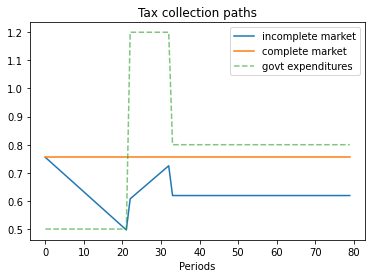

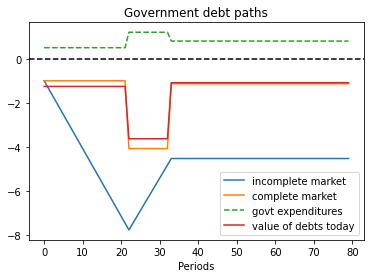

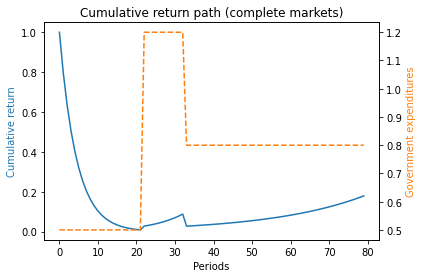

P 
 [[0.9 0.1 0. ]
 [0.  0.9 0.1]
 [0.  0.  1. ]]
Q 
 [[0.864 0.096 0.   ]
 [0.    0.864 0.096]
 [0.    0.    0.96 ]]
Govt expenditures in peace, war, postwar = [0.5 1.2 0.8]
Constant tax collections = 0.7548096885813149
Govt debt in 3 states = [-1.         -4.07093426 -1.12975779]

Government tax collections minus debt levels in peace, war, postwar
  T+b in peace = 1.754809688581315
  T+b in war = 4.825743944636679
  T+b in postwar = 1.8845674740484437

Total government spending in peace, war, postwar
  peace = 1.754809688581315
  war = 4.825743944636679
  postwar = 1.8845674740484437

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.1574074074074074
  π(war|peace) = 10.416666666666666
  π(war|war) = 1.1574074074074074
  π(postwar|war) = 10.416666666666666
  π(postwar|postwar) = 1.0416666666666667

Ex-ante returns to purchase of Arrow securities = 1.0416666666666667

The Ex-post one-period gross return on

In [11]:
ts_ex1 = TaxSmoothingExample(g_ex1, P_ex1, b0_ex1, states_ex1, random_state=1)
ts_ex1.display()

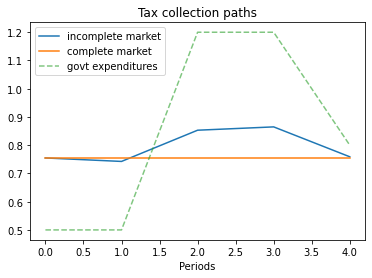

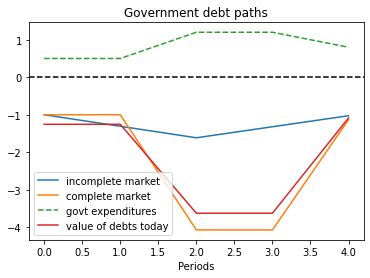

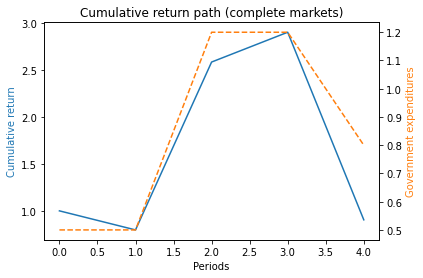

P 
 [[0.9 0.1 0. ]
 [0.  0.9 0.1]
 [0.  0.  1. ]]
Q 
 [[0.864 0.096 0.   ]
 [0.    0.864 0.096]
 [0.    0.    0.96 ]]
Govt expenditures in peace, war, postwar = [0.5 1.2 0.8]
Constant tax collections = 0.7548096885813149
Govt debt in 3 states = [-1.         -4.07093426 -1.12975779]

Government tax collections minus debt levels in peace, war, postwar
  T+b in peace = 1.754809688581315
  T+b in war = 4.825743944636679
  T+b in postwar = 1.8845674740484437

Total government spending in peace, war, postwar
  peace = 1.754809688581315
  war = 4.825743944636679
  postwar = 1.8845674740484437

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.1574074074074074
  π(war|peace) = 10.416666666666666
  π(war|war) = 1.1574074074074074
  π(postwar|war) = 10.416666666666666
  π(postwar|postwar) = 1.0416666666666667

Ex-ante returns to purchase of Arrow securities = 1.0416666666666667

The Ex-post one-period gross return on

In [12]:
# The following shows the use of the wrapper class when a specific state path is given
s_path = [0, 0, 1, 1, 2]
ts_s_path = TaxSmoothingExample(g_ex1, P_ex1, b0_ex1, states_ex1, s_path=s_path)
ts_s_path.display()

### Example 2

This example captures a peace followed by a war, eventually followed by a  permanent peace .

Here we set

$$
P =
\begin{bmatrix}
    1    & 0        & 0      \cr
    0    & 1-\gamma & \gamma \cr
    \phi & 0        & 1-\phi
\end{bmatrix}
$$

where the government expenditure vector $g = \begin{bmatrix} g_L & g_L & g_H \end{bmatrix}$ and where $g_L < g_H$.

We assume $b_0 = 1$ and that the initial Markov state is state $2$ so that the system starts off in a temporary peace.

In [13]:
g_ex2 = [g_L, g_L, g_H]
P_ex2 = np.array([[1,   0,    0],
                  [0, 1-γ,    γ],
                  [ϕ,   0, 1-ϕ]])
b0_ex2 = 1
states_ex2 = ['peace', 'temporary peace', 'war']

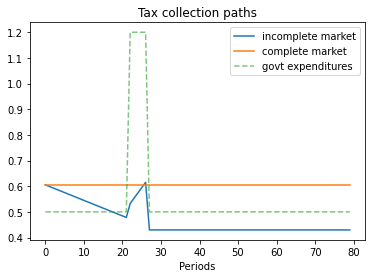

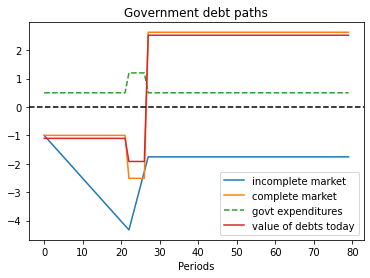

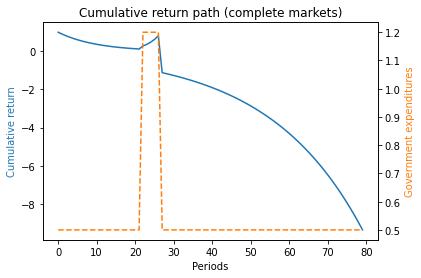

P 
 [[1.  0.  0. ]
 [0.  0.9 0.1]
 [0.1 0.  0.9]]
Q 
 [[0.96  0.    0.   ]
 [0.    0.864 0.096]
 [0.096 0.    0.864]]
Govt expenditures in peace, temporary peace, war = [0.5 0.5 1.2]
Constant tax collections = 0.6053287197231834
Govt debt in 3 states = [ 2.63321799 -1.         -2.51384083]

Government tax collections minus debt levels in peace, temporary peace, war
  T+b in peace = -2.027889273356399
  T+b in temporary peace = 1.6053287197231834
  T+b in war = 3.1191695501730106

Total government spending in peace, temporary peace, war
  peace = -2.027889273356399
  temporary peace = 1.6053287197231834
  war = 3.119169550173011

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace|peace) = 1.0416666666666667
  π(temporary peace|temporary peace) = 1.1574074074074074
  π(war|temporary peace) = 10.416666666666666
  π(peace|war) = 10.416666666666666
  π(war|war) = 1.1574074074074074

Ex-ante returns to purchase of Arrow secu

In [14]:
ts_ex2 = TaxSmoothingExample(g_ex2, P_ex2, b0_ex2, states_ex2, init=1, random_state=1)
ts_ex2.display()

### Example 3

This example features a situation in which one of the states is a war state with no hope of peace next period, while another state
is a war state with a positive probability of peace next period.

The Markov chain is:

$$
P =
\begin{bmatrix}
            1 - \lambda & \lambda  & 0      & 0         \cr
    0           & 1 - \phi & \phi   & 0         \cr
    0           & 0        & 1-\psi & \psi      \cr
    \theta      & 0        & 0      & 1 - \theta
\end{bmatrix}
$$

with government expenditure levels for the four states being
$\begin{bmatrix} g_L & g_L & g_H & g_H \end{bmatrix}$ where $g_L < g_H$.

We start with $b_0 = 1$ and $s_0 = 1$.

In [15]:
g_ex3 = [g_L, g_L, g_H, g_H]
P_ex3 = np.array([[1-λ,  λ,   0,    0],
                  [0,  1-ϕ,   ϕ,     0],
                  [0,    0,  1-ψ,    ψ],
                  [θ,    0,    0,  1-θ ]])
b0_ex3 = 1
states_ex3 = ['peace1', 'peace2', 'war1', 'war2']

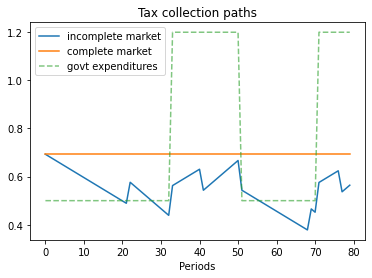

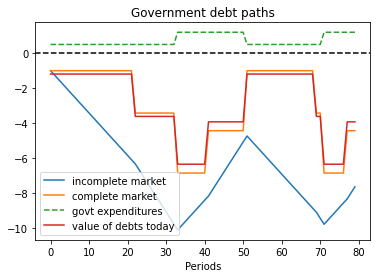

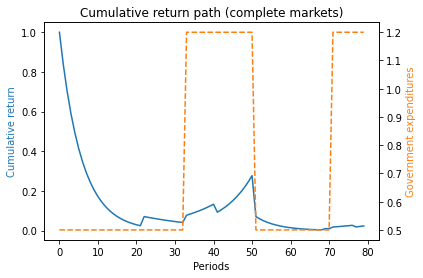

P 
 [[0.9 0.1 0.  0. ]
 [0.  0.9 0.1 0. ]
 [0.  0.  0.9 0.1]
 [0.1 0.  0.  0.9]]
Q 
 [[0.864 0.096 0.    0.   ]
 [0.    0.864 0.096 0.   ]
 [0.    0.    0.864 0.096]
 [0.096 0.    0.    0.864]]
Govt expenditures in peace1, peace2, war1, war2 = [0.5 0.5 1.2 1.2]
Constant tax collections = 0.6927944572748268
Govt debt in 4 states = [-1.         -3.42494226 -6.86027714 -4.43533487]

Government tax collections minus debt levels in peace1, peace2, war1, war2
  T+b in peace1 = 1.6927944572748268
  T+b in peace2 = 4.117736720554273
  T+b in war1 = 7.553071593533488
  T+b in war2 = 5.1281293302540405

Total government spending in peace1, peace2, war1, war2
  peace1 = 1.6927944572748268
  peace2 = 4.117736720554273
  war1 = 7.553071593533487
  war2 = 5.1281293302540405

Let's see ex-post and ex-ante returns on Arrow securities 

Ex-post returns to purchase of Arrow securities:
  π(peace1|peace1) = 1.1574074074074074
  π(peace2|peace1) = 10.416666666666666
  π(peace2|peace2) = 1.1574074074074074

In [16]:
ts_ex3 = TaxSmoothingExample(g_ex3, P_ex3, b0_ex3, states_ex3, random_state=1)
ts_ex3.display()

### Example 4

Here the Markov chain is:

$$
P =
\begin{bmatrix}
            1 - \lambda & \lambda  & 0      & 0          & 0      \cr
            0           & 1 - \phi & \phi   & 0          & 0      \cr
    0           & 0        & 1-\psi & \psi       & 0      \cr
    0           & 0        & 0      & 1 - \theta & \theta \cr
    0           & 0        & 0      & 0          & 1
\end{bmatrix}
$$

with government expenditure levels for the five states being
$\begin{bmatrix} g_L & g_L & g_H & g_H & g_L \end{bmatrix}$ where $g_L < g_H$.

We ssume that $b_0 = 1$ and $s_0 = 1$.

In [17]:
g_ex4 = [g_L, g_L, g_H, g_H, g_L]
P_ex4 = np.array([[1-λ,  λ,   0,     0,    0],
                  [0,  1-ϕ,   ϕ,     0,    0],
                  [0,    0,  1-ψ,    ψ,    0],
                  [0,    0,    0,   1-θ,   θ],
                  [0,    0,    0,     0,   1]])
b0_ex4 = 1
states_ex4 = ['peace1', 'peace2', 'war1', 'war2', 'permanent peace']

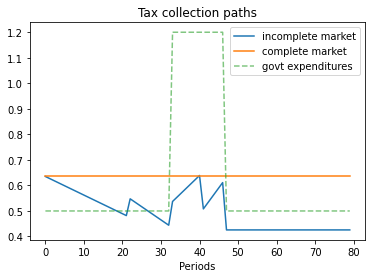

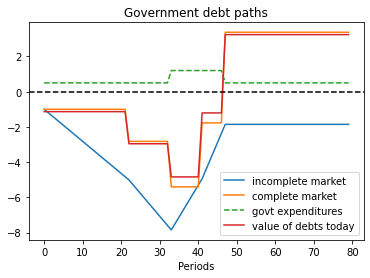

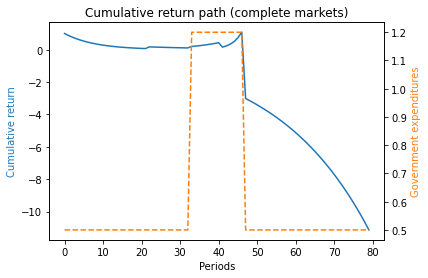

P 
 [[0.9 0.1 0.  0.  0. ]
 [0.  0.9 0.1 0.  0. ]
 [0.  0.  0.9 0.1 0. ]
 [0.  0.  0.  0.9 0.1]
 [0.  0.  0.  0.  1. ]]
Q 
 [[0.864 0.096 0.    0.    0.   ]
 [0.    0.864 0.096 0.    0.   ]
 [0.    0.    0.864 0.096 0.   ]
 [0.    0.    0.    0.864 0.096]
 [0.    0.    0.    0.    0.96 ]]
Govt expenditures in peace1, peace2, war1, war2, permanent peace = [0.5 0.5 1.2 1.2 0.5]
Constant tax collections = 0.6349979047185738
Govt debt in 5 states = [-1.         -2.82289484 -5.4053292  -1.77211121  3.37494762]

Government tax collections minus debt levels in peace1, peace2, war1, war2, permanent peace
  T+b in peace1 = 1.6349979047185736
  T+b in peace2 = 3.4578927455370505
  T+b in war1 = 6.040327103363229
  T+b in war2 = 2.407109110283644
  T+b in permanent peace = -2.739949713245767

Total government spending in peace1, peace2, war1, war2, permanent peace
  peace1 = 1.6349979047185736
  peace2 = 3.457892745537051
  war1 = 6.040327103363228
  war2 = 2.407109110283644
  permanent peace = -

In [18]:
ts_ex4 = TaxSmoothingExample(g_ex4, P_ex4, b0_ex4, states_ex4, random_state=1)
ts_ex4.display()

### Example 5

The  example captures a case when  the system follows a deterministic path from peace to war, and back to peace again.

Since there is no randomness, the outcomes in complete markets setting should be the same as in incomplete markets setting.

The Markov chain is:

$$
P =
\begin{bmatrix}
            0 & 1 & 0 & 0 & 0 & 0 & 0 \cr
    0 & 0 & 1 & 0 & 0 & 0 & 0 \cr
    0 & 0 & 0 & 1 & 0 & 0 & 0 \cr
    0 & 0 & 0 & 0 & 1 & 0 & 0 \cr
    0 & 0 & 0 & 0 & 0 & 1 & 0 \cr
    0 & 0 & 0 & 0 & 0 & 0 & 1 \cr
    0 & 0 & 0 & 0 & 0 & 0 & 1 \cr
\end{bmatrix}
$$

with government expenditure levels for the seven states being
$\begin{bmatrix} g_L & g_L & g_H & g_H &  g_H & g_H & g_L \end{bmatrix}$ where
$g_L < g_H$. Assume $b_0 = 1$ and $s_0 = 1$.

In [19]:
g_ex5 = [g_L, g_L, g_H, g_H, g_H, g_H, g_L]
P_ex5 = np.array([[0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0, 1]])
b0_ex5 = 1
states_ex5 = ['peace1', 'peace2', 'war1', 'war2', 'war3', 'permanent peace']

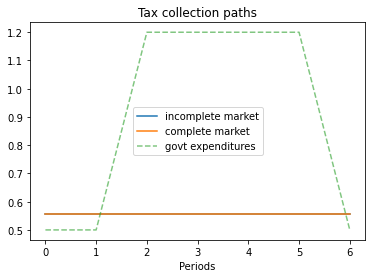

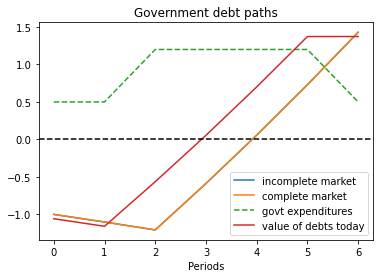

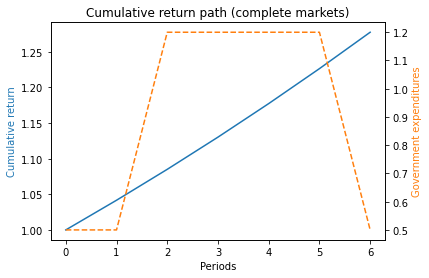

P 
 [[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]]
Q 
 [[0.   0.96 0.   0.   0.   0.   0.  ]
 [0.   0.   0.96 0.   0.   0.   0.  ]
 [0.   0.   0.   0.96 0.   0.   0.  ]
 [0.   0.   0.   0.   0.96 0.   0.  ]
 [0.   0.   0.   0.   0.   0.96 0.  ]
 [0.   0.   0.   0.   0.   0.   0.96]
 [0.   0.   0.   0.   0.   0.   0.96]]
Govt expenditures in peace1, peace2, war1, war2, war3, permanent peace = [0.5 0.5 1.2 1.2 1.2 1.2 0.5]
Constant tax collections = 0.5571895472128002
Govt debt in 6 states = [-1.         -1.10123911 -1.20669652 -0.58738132  0.05773868  0.72973868
  1.42973868]

Government tax collections minus debt levels in peace1, peace2, war1, war2, war3, permanent peace
  T+b in peace1 = 1.5571895472128001
  T+b in peace2 = 1.6584286588928006
  T+b in war1 = 1.7638860668928005
  T+b in war2 = 1.1445708668928007
  T+b in war3 = 0.499450866892801
  T+b in permanent peace = -0.1725491331071991

Total government spe

In [20]:
ts_ex5 = TaxSmoothingExample(g_ex5, P_ex5, b0_ex5, states_ex5, N_simul=7, random_state=1)
ts_ex5.display()

### Continuous-State Gaussian Model

To construct a tax-smoothing version of the  complete markets consumption-smoothing model with a continuous state space that we presented in
the lecture {doc}`consumption smoothing with complete and incomplete markets <smoothing>`, we simply relabel variables.

Thus,  a government  faces a sequence of budget constraints

$$
T_t + b_t = g_t + \beta \mathbb E_t b_{t+1}, \quad t \geq 0
$$

where $T_t$ is tax revenues, $b_t$ are receipts at $t$ from contingent claims that the government had *purchased* at time $t-1$,
and

$$
\beta \mathbb E_t b_{t+1} \equiv \int q_{t+1}(x_{t+1} | x_t) b_{t+1}(x_{t+1}) d x_{t+1}
$$

is the value of time $t+1$ state-contingent claims purchased  by the government  at time $t$.

As above with the consumption-smoothing model, we can solve the time $t$ budget constraint forward to obtain

$$
b_t = \mathbb E_t  \sum_{j=0}^\infty \beta^j (g_{t+j} - T_{t+j} )
$$

which can be rearranged to become

$$
\mathbb E_t  \sum_{j=0}^\infty \beta^j g_{t+j}  = b_t + \mathbb E_t \sum_{j=0}^\infty \beta^j T_{t+j}
$$

which states that the present value of government purchases equals the value of government assets at $t$ plus the present value of tax
receipts.

With these relabelings, examples presented in {doc}`consumption smoothing with complete and incomplete markets <smoothing>` can be
interpreted as tax-smoothing models.

**Returns:** In the continuous state version of our incomplete markets model, the  ex post one-period   gross  rate of return on the government portfolio equals

$$
R(x_{t+1} | x_t) = \frac{b(x_{t+1})}{\beta E b(x_{t+1})| x_t}
$$

#### Related Lectures

Throughout this lecture, we have taken one-period interest rates and Arrow security prices as exogenous objects determined outside the model
and specified them in ways designed to align our models closely with the consumption smoothing model of Barro {cite}`Barro1979`.

Other lectures make these objects endogenous and describe  how a government  optimally  manipulates prices of government debt, albeit indirectly via effects distorting
taxes have on equilibrium prices and allocations.

In {doc}`optimal taxation in an LQ economy <lqramsey>` and {doc}`recursive optimal taxation <opt_tax_recur>`, we study **complete-markets**
models in which the government recognizes that it can manipulate  Arrow securities prices.

Linear-quadratic versions of the Lucas-Stokey tax-smoothing model are described in {doc}`Optimal Taxation in an LQ Economy <lqramsey>`.

That lecture is a warm-up for the non-linear-quadratic model of tax smoothing described in {doc}`Optimal Taxation with State-Contingent Debt <opt_tax_recur>`.

In both {doc}`Optimal Taxation in an LQ Economy <lqramsey>` and {doc}`Optimal Taxation with State-Contingent Debt <opt_tax_recur>`, the government  recognizes that its decisions affect prices.

In {doc}`optimal taxation with incomplete markets <amss>`, we study an **incomplete-markets** model in which the
government also manipulates  prices of government debt.